# Predicting survival of passengers on the Titanic using a Random Forest Classifier

Inspired by the approach of user danielv7 on Kaggle, link to which is this: https://www.kaggle.com/danielv7/basic-approach-for-top-3-in-the-titanic

Step 1: Importing libraries


In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

print("Library imports complete")

Library imports complete


In [2]:
# Loading training data into a pandas dataframe

train_df = pd.read_csv('train.csv')
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Basic characteristics of training data

print("Training data shape: ",train_df.shape)
print("Training data columns: ", list(train_df.columns))


Training data shape:  (891, 12)
Training data columns:  ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


In [4]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:

# Checking for null values

train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


Since most values in Cabin are missing (687/891 -> almost 80%), we can create a variable that denotes if a person was assigned a cabin. We can use the value 1 to denote that the person was assigned a cabin, and 0 if they were not.

In [6]:
train_df['HasCabin'] = train_df['Cabin'].notna().astype(int) 
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HasCabin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


We no longer need the Cabin variable

In [7]:
train_df = train_df.drop(columns= 'Cabin', errors='ignore')
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,HasCabin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,0


Embarked also has a couple of missing values, so we replace this with the mode of Embarked

In [8]:
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace=True)
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         0
HasCabin         0
dtype: int64

There are also several missing ages, but we will handle them later.

Checking to see if PassengerId and Ticket consists entirely of unique values (we expect this to be the case)

In [9]:
print(train_df['PassengerId'].value_counts().sum())
print(train_df['Ticket'].value_counts().sum())

891
891


Since both the columns consist entirely of unique values, we can safely drop them

In [10]:
train_df = train_df.drop(columns = ['PassengerId','Ticket'], errors='ignore')
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,HasCabin
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,1
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,1
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,0


One hot encoding the categorical variable Embarked 

In [11]:
embarked_dummies = pd.get_dummies(train_df['Embarked'], prefix = 'Embarked')
train_df = pd.concat([train_df, embarked_dummies], axis = 1)
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,HasCabin,Embarked_C,Embarked_Q,Embarked_S
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,0,0,0,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,1,1,0,0
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,0,0,0,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,1,0,0,1
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,0,0,0,1


We can also one-hot encode the passenger class. We choose to do this since it is an ordinal variable, and we cannot safely assume that the distribution of passengers among the three classes is continuous

In [12]:
class_dummies = pd.get_dummies(train_df['Pclass'], prefix = 'Class')
train_df = pd.concat([train_df, class_dummies], axis = 1)
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,HasCabin,Embarked_C,Embarked_Q,Embarked_S,Class_1,Class_2,Class_3
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,0,0,0,1,0,0,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,1,1,0,0,1,0,0
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,0,0,0,1,0,0,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,1,0,0,1,1,0,0
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,0,0,0,1,0,0,1


We can also convert the sex variable to a numerical one by encoding Females as 1 and Males as 0

In [13]:
train_df['Sex'] = (train_df['Sex']=='female').astype(int)
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,HasCabin,Embarked_C,Embarked_Q,Embarked_S,Class_1,Class_2,Class_3
0,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,S,0,0,0,1,0,0,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,C,1,1,0,0,1,0,0
2,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,S,0,0,0,1,0,0,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,S,1,0,0,1,1,0,0
4,0,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,S,0,0,0,1,0,0,1


Our database is getting pretty congested, so we can drop the Embarked and Pclass columns since the values have already undergone one-hot encoding

In [14]:
train_df = train_df.drop(columns = ['Pclass', 'Embarked'], errors='ignore')
train_df.head()

,Survived,Name,Sex,Age,SibSp,Parch,Fare,HasCabin,Embarked_C,Embarked_Q,Embarked_S,Class_1,Class_2,Class_3
0,0,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,0,0,0,1,0,0,1
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,1,1,0,0,1,0,0
2,1,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,0,0,0,1,0,0,1
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,1,0,0,1,1,0,0
4,0,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,0,0,0,1,0,0,1


Now we can go through all the names and see if we can learn anything from the titles

In [15]:
names = train_df['Name']
 
# We first go through all the names and extract the titles- they are between the comma and period of each name
titles = {}
for name in names:
    i, j = [name.find(','), name.find('.')]
    temp = name[i+1: j].strip()
    if temp in titles:
        titles[temp] += 1
    else:
        titles[temp] = 1
titles

{'Mr': 517,
 'Mrs': 125,
 'Miss': 182,
 'Master': 40,
 'Don': 1,
 'Rev': 6,
 'Dr': 7,
 'Mme': 1,
 'Ms': 1,
 'Major': 2,
 'Lady': 1,
 'Sir': 1,
 'Mlle': 2,
 'Col': 2,
 'Capt': 1,
 'the Countess': 1,
 'Jonkheer': 1}

We can group titles in the following way-

- Mr, Master - Male titles
- Mrs, Miss, Ms, Mme, Mlle - Female titles
- Don, Rev, Dr, Major, Lady, Sir, Col, Capt, the Countess, Jonkheer - Rare

In [16]:
male_titles = ['Mr', 'Master']
female_titles = ['Mrs', 'Miss', 'Ms', 'Mme', 'Mlle']
rare_titles = ['Don', 'Rev', 'Dr', 'Major', 'Lady', 'Sir', 'Col', 'Capt', 'the Countess', 'Jonkheer']


# Creating a title column in train_df
train_df['Title'] = [(x[x.find(',')+2 : x.find('.')].strip()) for x in train_df['Name']]

# Replacing Title column in train_df with either 'male' , 'female' or 'rare' and then one-hot encoding these

train_df['Title'] = train_df['Title'].replace(male_titles, 'male')
train_df['Title'] = train_df['Title'].replace(female_titles, 'female')
train_df['Title'] = train_df['Title'].replace(rare_titles, 'rare')

# One-hot encoding
title_dummies = pd.get_dummies(train_df['Title'], prefix = 'Title')

train_df = pd.concat([train_df,title_dummies], axis=1)
train_df

,Survived,Name,Sex,Age,SibSp,Parch,Fare,HasCabin,Embarked_C,Embarked_Q,Embarked_S,Class_1,Class_2,Class_3,Title,Title_female,Title_male,Title_rare
0,0,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,0,0,0,1,0,0,1,male,0,1,0
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,1,1,0,0,1,0,0,female,1,0,0
2,1,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,0,0,0,1,0,0,1,female,1,0,0
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,1,0,0,1,1,0,0,female,1,0,0
4,0,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,0,0,0,1,0,0,1,male,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,"Montvila, Rev. Juozas",0,27.0,0,0,13.0000,0,0,0,1,0,1,0,rare,0,0,1
887,1,"Graham, Miss. Margaret Edith",1,19.0,0,0,30.0000,1,0,0,1,1,0,0,female,1,0,0
888,0,"Johnston, Miss. Catherine Helen ""Carrie""",1,NaN,1,2,23.4500,0,0,0,1,0,0,1,female,1,0,0
889,1,"Behr, Mr. Karl Howell",0,26.0,0,0,30.0000,1,1,0,0,1,0,0,male,0,1,0


In [17]:
# We can drop the Title and Name columns now
train_df = train_df.drop(columns = ['Title','Name'], errors='ignore')
train_df

,Survived,Sex,Age,SibSp,Parch,Fare,HasCabin,Embarked_C,Embarked_Q,Embarked_S,Class_1,Class_2,Class_3,Title_female,Title_male,Title_rare
0,0,0,22.0,1,0,7.2500,0,0,0,1,0,0,1,0,1,0
1,1,1,38.0,1,0,71.2833,1,1,0,0,1,0,0,1,0,0
2,1,1,26.0,0,0,7.9250,0,0,0,1,0,0,1,1,0,0
3,1,1,35.0,1,0,53.1000,1,0,0,1,1,0,0,1,0,0
4,0,0,35.0,0,0,8.0500,0,0,0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0,27.0,0,0,13.0000,0,0,0,1,0,1,0,0,0,1
887,1,1,19.0,0,0,30.0000,1,0,0,1,1,0,0,1,0,0
888,0,1,NaN,1,2,23.4500,0,0,0,1,0,0,1,1,0,0
889,1,0,26.0,0,0,30.0000,1,1,0,0,1,0,0,0,1,0


We still have to deal with the missing ages. I am choosing to use forward filling to replace the ages in this case

In [18]:
# train_df['Age'].fillna(method='ffill', inplace=True)
# train_df['Family'] = train_df['SibSp']+train_df['Parch']
# train_df = train_df.drop(columns=['SibSp', 'Parch'])
train_df['Age'].fillna(train_df['Age'].mean(), inplace=True)

In [19]:
# Checking that we have no null values remaining
train_df.isnull().sum()

Survived        0
Sex             0
Age             0
SibSp           0
Parch           0
Fare            0
HasCabin        0
Embarked_C      0
Embarked_Q      0
Embarked_S      0
Class_1         0
Class_2         0
Class_3         0
Title_female    0
Title_male      0
Title_rare      0
dtype: int64

Examining the distribution of values for each of the numerical variables in the dataset

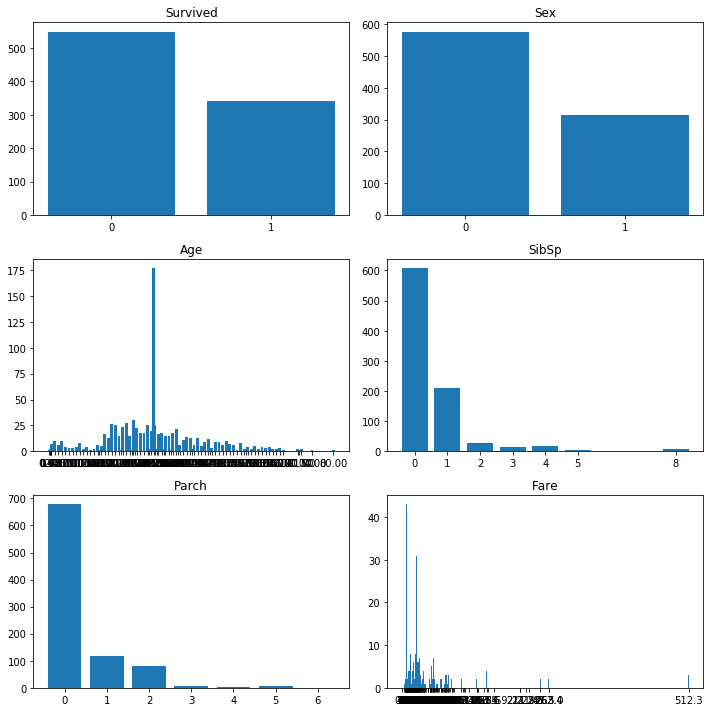

In [20]:
# Plotting survivors
figure, axes = plt.subplots(3, 2, figsize=(10,10))

labels = train_df.columns[0:6]
rows = 3
cols = 2

for i in range(rows):
    for j in range(cols):
        index = 2*i + j
        axes[i,j].set_title(labels[index])
        axes[i,j].bar(train_df[labels[index]].value_counts().index, train_df[labels[index]].value_counts())
        axes[i,j].set_xticks(train_df[labels[index]].value_counts().index)
plt.tight_layout()

The distribution for Fare is extremely right skewed, hence we normalize it using a log distribution

In [21]:
train_df['Fare'] = train_df['Fare'].map(lambda x: np.log(x) if x>0 else 0)

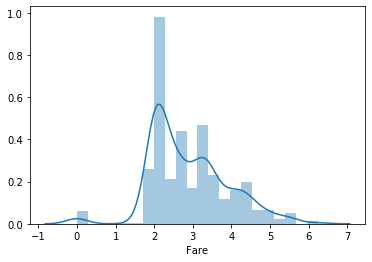

In [22]:
# Plotting train_df again
sns.distplot(train_df['Fare']);

The distribution is visibly much more normal

### Now it's time for preparing our features and labels

In [23]:
y = train_df['Survived']
X = train_df.drop(columns = 'Survived', errors='ignore')

Now we split our features and labels into a training and validation set- we split about 75% for the training set and 25% for the validation set 

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X,y, test_size = 0.25, random_state = 2)

Time to build the random forest classifier! Starting off with 500 estimators and a max depth of 8

In [25]:
# Importing model to use
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# Instantiate model with 500 decision trees and max depth of 8
rf_classifier = RandomForestClassifier(n_estimators = 500, random_state= 42, max_depth=8)

# Train the model on training sets
rf_classifier.fit(X_train, y_train);

Predicting the accuracy of the model on the validation set


In [26]:

predictions = rf_classifier.predict(X_validation)
accuracy = (predictions == y_validation).sum()/len(y_validation)
accuracy

0.8071748878923767

Classification report showing our predictions vs the actual result

In [27]:

from sklearn.metrics import classification_report
print(classification_report(y_validation,predictions))

              precision    recall  f1-score   support

           0       0.77      0.95      0.85       131
           1       0.90      0.60      0.72        92

    accuracy                           0.81       223
   macro avg       0.84      0.78      0.79       223
weighted avg       0.83      0.81      0.80       223



### Hyperparameter Tuning

Here, I aim to test different combinations of the number of decision trees and the maximum depth of each decision tree in order to find the combination that gives the best result on the validation set

Max accuracy=  0.8071748878923767  at number of estimators=  50


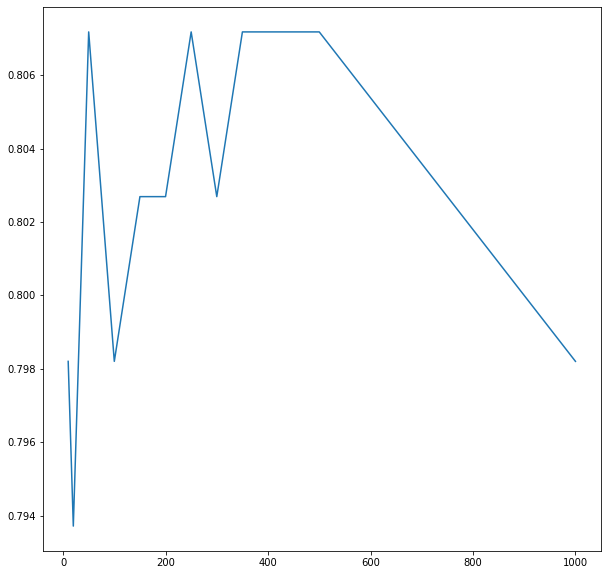

In [28]:
figure, axis = plt.subplots(figsize=(10,10))
estimators = [10,20,50,100,150,200,250,300,350,400,450,500,1000]
accuracies = []
max_accuracy = 0
max_i = 0
for i in estimators:
    classifier = RandomForestClassifier(n_estimators = i, random_state= 42, max_depth=8)
    classifier.fit(X_train, y_train)
    predictions = classifier.predict(X_validation)
    accuracy = (predictions == y_validation).sum()/len(y_validation)
    accuracies.append(accuracy)
    if accuracy>max_accuracy:
        max_accuracy = accuracy
        max_i = i
plt.plot(estimators, accuracies);
print('Max accuracy= ',max_accuracy,' at number of estimators= ',max_i)

Max accuracy=  0.8295964125560538  at depth=  11


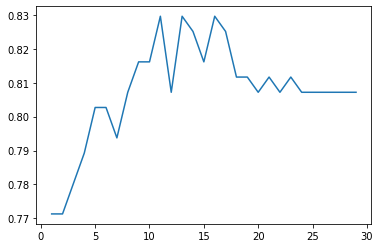

In [29]:
depths = [i for i in range(1,30)]
accuracies = []
max_accuracy = 0
max_i = 0
for i in depths:
    classifier = RandomForestClassifier(n_estimators = 50, random_state= 42, max_depth=i)
    classifier.fit(X_train, y_train)
    predictions = classifier.predict(X_validation)
    accuracy = (predictions == y_validation).sum()/len(y_validation)
    accuracies.append(accuracy)
    if accuracy>max_accuracy:
        max_accuracy = accuracy
        max_i = i
plt.plot(depths, accuracies);
print('Max accuracy= ',max_accuracy,' at depth= ',max_i)

Therefore, we seem to get best classification accuracy on the validation set with n_estimators= 50,300 and any number from 400-500 and max_depth=11,13 or 17

In [30]:
#Retraining the classifier with 300 decision trees and a max depth of 11
rf_classifier = RandomForestClassifier(n_estimators = 300, random_state= 42, max_depth=11)

# Train the model on training sets
rf_classifier.fit(X_train, y_train);

## Predicting Test set

Reading test data from csv


In [31]:
test_df = pd.read_csv('test.csv')
test_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


Checking if any data is missing

In [32]:
test_df.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [33]:
# changing sex to 1s and 0s
test_df['Sex'] = (test_df['Sex'] == 'female').astype(int)

In [34]:
# checking if passenger has a cabin
test_df['HasCabin'] = test_df['Cabin'].notna().astype(int)

In [35]:
# One-hot encoding the Pclass and Embarked columns
embarked_dummies = pd.get_dummies(test_df['Embarked'],prefix='Embarked')
class_dummies = pd.get_dummies(test_df['Pclass'], prefix = 'Class')
test_df = pd.concat([test_df,embarked_dummies, class_dummies], axis=1)
test_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HasCabin,Embarked_C,Embarked_Q,Embarked_S,Class_1,Class_2,Class_3
0,892,3,"Kelly, Mr. James",0,34.5,0,0,330911,7.8292,NaN,Q,0,0,1,0,0,0,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,363272,7.0000,NaN,S,0,0,0,1,0,0,1
2,894,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,240276,9.6875,NaN,Q,0,0,1,0,0,1,0
3,895,3,"Wirz, Mr. Albert",0,27.0,0,0,315154,8.6625,NaN,S,0,0,0,1,0,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,3101298,12.2875,NaN,S,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",0,NaN,0,0,A.5. 3236,8.0500,NaN,S,0,0,0,1,0,0,1
414,1306,1,"Oliva y Ocana, Dona. Fermina",1,39.0,0,0,PC 17758,108.9000,C105,C,1,1,0,0,1,0,0
415,1307,3,"Saether, Mr. Simon Sivertsen",0,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0,0,0,1,0,0,1
416,1308,3,"Ware, Mr. Frederick",0,NaN,0,0,359309,8.0500,NaN,S,0,0,0,1,0,0,1


In [36]:
# Replacing missing ages with mean age and missing fare with mean fare
test_df['Age'].fillna(test_df['Age'].mean(), inplace=True)
test_df['Fare'].fillna(test_df.Fare.mean(), inplace=True)
test_df.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
HasCabin         0
Embarked_C       0
Embarked_Q       0
Embarked_S       0
Class_1          0
Class_2          0
Class_3          0
dtype: int64

In [37]:
# Removing columns PassengerId, Pclass, Ticket, Cabin and Embarked
ids = test_df.PassengerId

test_df = test_df.drop(columns = ['PassengerId','Pclass','Ticket','Cabin','Embarked'], errors='ignore')

test_df

,Name,Sex,Age,SibSp,Parch,Fare,HasCabin,Embarked_C,Embarked_Q,Embarked_S,Class_1,Class_2,Class_3
0,"Kelly, Mr. James",0,34.50000,0,0,7.8292,0,0,1,0,0,0,1
1,"Wilkes, Mrs. James (Ellen Needs)",1,47.00000,1,0,7.0000,0,0,0,1,0,0,1
2,"Myles, Mr. Thomas Francis",0,62.00000,0,0,9.6875,0,0,1,0,0,1,0
3,"Wirz, Mr. Albert",0,27.00000,0,0,8.6625,0,0,0,1,0,0,1
4,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.00000,1,1,12.2875,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,"Spector, Mr. Woolf",0,30.27259,0,0,8.0500,0,0,0,1,0,0,1
414,"Oliva y Ocana, Dona. Fermina",1,39.00000,0,0,108.9000,1,1,0,0,1,0,0
415,"Saether, Mr. Simon Sivertsen",0,38.50000,0,0,7.2500,0,0,0,1,0,0,1
416,"Ware, Mr. Frederick",0,30.27259,0,0,8.0500,0,0,0,1,0,0,1


In [38]:
# Checking if titles in test_df are same as those in train_df

names_test = test_df['Name']
 
# We first go through all the names and extract the titles- they are between the comma and period of each name
titles_test = {}
for name in names_test:
    i, j = [name.find(','), name.find('.')]
    temp = name[i+1: j].strip()
    if temp in titles_test:
        titles_test[temp] += 1
    else:
        titles_test[temp] = 1
titles_test

{'Mr': 240,
 'Mrs': 72,
 'Miss': 78,
 'Master': 21,
 'Ms': 1,
 'Col': 2,
 'Rev': 2,
 'Dr': 1,
 'Dona': 1}

In [39]:
# These are largely similar to those in the training dataset, hence we can use similar categories

male_titles = ['Mr', 'Master']
female_titles = ['Mrs', 'Miss', 'Ms', 'Mme', 'Mlle']
rare_titles = ['Don', 'Dona', 'Rev', 'Dr', 'Major', 'Lady', 'Sir', 'Col', 'Capt', 'the Countess', 'Jonkheer']


# Creating a title column in train_df
test_df['Title'] = [(x[x.find(',')+2 : x.find('.')].strip()) for x in test_df['Name']]

# Replacing Title column in train_df with either 'male' , 'female' or 'rare' and then one-hot encoding these

test_df['Title'] = test_df['Title'].replace(male_titles, 'male')
test_df['Title'] = test_df['Title'].replace(female_titles, 'female')
test_df['Title'] = test_df['Title'].replace(rare_titles, 'rare')

# One-hot encoding
title_dummies = pd.get_dummies(test_df['Title'], prefix = 'Title')

test_df = pd.concat([test_df,title_dummies], axis=1)
test_df

,Name,Sex,Age,SibSp,Parch,Fare,HasCabin,Embarked_C,Embarked_Q,Embarked_S,Class_1,Class_2,Class_3,Title,Title_female,Title_male,Title_rare
0,"Kelly, Mr. James",0,34.50000,0,0,7.8292,0,0,1,0,0,0,1,male,0,1,0
1,"Wilkes, Mrs. James (Ellen Needs)",1,47.00000,1,0,7.0000,0,0,0,1,0,0,1,female,1,0,0
2,"Myles, Mr. Thomas Francis",0,62.00000,0,0,9.6875,0,0,1,0,0,1,0,male,0,1,0
3,"Wirz, Mr. Albert",0,27.00000,0,0,8.6625,0,0,0,1,0,0,1,male,0,1,0
4,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.00000,1,1,12.2875,0,0,0,1,0,0,1,female,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,"Spector, Mr. Woolf",0,30.27259,0,0,8.0500,0,0,0,1,0,0,1,male,0,1,0
414,"Oliva y Ocana, Dona. Fermina",1,39.00000,0,0,108.9000,1,1,0,0,1,0,0,rare,0,0,1
415,"Saether, Mr. Simon Sivertsen",0,38.50000,0,0,7.2500,0,0,0,1,0,0,1,male,0,1,0
416,"Ware, Mr. Frederick",0,30.27259,0,0,8.0500,0,0,0,1,0,0,1,male,0,1,0


In [40]:
# Removing title and name columns
test_df = test_df.drop(columns = ['Title','Name'])
test_df

,Sex,Age,SibSp,Parch,Fare,HasCabin,Embarked_C,Embarked_Q,Embarked_S,Class_1,Class_2,Class_3,Title_female,Title_male,Title_rare
0,0,34.50000,0,0,7.8292,0,0,1,0,0,0,1,0,1,0
1,1,47.00000,1,0,7.0000,0,0,0,1,0,0,1,1,0,0
2,0,62.00000,0,0,9.6875,0,0,1,0,0,1,0,0,1,0
3,0,27.00000,0,0,8.6625,0,0,0,1,0,0,1,0,1,0
4,1,22.00000,1,1,12.2875,0,0,0,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,0,30.27259,0,0,8.0500,0,0,0,1,0,0,1,0,1,0
414,1,39.00000,0,0,108.9000,1,1,0,0,1,0,0,0,0,1
415,0,38.50000,0,0,7.2500,0,0,0,1,0,0,1,0,1,0
416,0,30.27259,0,0,8.0500,0,0,0,1,0,0,1,0,1,0


In [41]:
# Normalising the distribution for fare
test_df['Fare'] = test_df['Fare'].map(lambda x: np.log(x) if x>0 else 0)

In [42]:
test_df

,Sex,Age,SibSp,Parch,Fare,HasCabin,Embarked_C,Embarked_Q,Embarked_S,Class_1,Class_2,Class_3,Title_female,Title_male,Title_rare
0,0,34.50000,0,0,2.057860,0,0,1,0,0,0,1,0,1,0
1,1,47.00000,1,0,1.945910,0,0,0,1,0,0,1,1,0,0
2,0,62.00000,0,0,2.270836,0,0,1,0,0,1,0,0,1,0
3,0,27.00000,0,0,2.159003,0,0,0,1,0,0,1,0,1,0
4,1,22.00000,1,1,2.508582,0,0,0,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,0,30.27259,0,0,2.085672,0,0,0,1,0,0,1,0,1,0
414,1,39.00000,0,0,4.690430,1,1,0,0,1,0,0,0,0,1
415,0,38.50000,0,0,1.981001,0,0,0,1,0,0,1,0,1,0
416,0,30.27259,0,0,2.085672,0,0,0,1,0,0,1,0,1,0


In [43]:
# Extracting features
X_test = test_df.values
print(X_test.shape)

(418, 15)


In [44]:
# Making predictions
classifier = RandomForestClassifier(n_estimators=50, random_state=42, max_depth=8)
classifier.fit(X_train,y_train)
validation_predictions = classifier.predict(X_validation)
validation_accuracy = (validation_predictions == y_validation).sum()/len(y_validation)
validation_accuracy

0.8071748878923767

In [45]:
test_predictions = classifier.predict(X_test)
test_predictions

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [46]:
output_csv= pd.DataFrame({
    'PassengerId': ids,
    'Survived': test_predictions
})
output_csv.to_csv('Predictions_RF_2.csv', index=None)